# DSKUS Group 1 EDA
## Names below

### Kyi Moe Tun

### The Global Carbon Project's Fossil CO₂ Emissions Dataset

The Global Carbon Project (GCP) was established in 2001 and has been publishing estimates of global and national fossil CO₂ emissions since that time. The GCP is one of 20 Global Research Projects under Future Earth and aims to develop a complete picture of the global carbon cycle, including its biophysical and human dimensions. The GCP's fossil CO₂ emissions dataset is a component of the Global Carbon Budget, which balances source and sink components of carbon dioxide.

In the early years, the GCP's fossil CO₂ emissions dataset was taken directly from the Carbon Dioxide Information Analysis Center (CDIAC) of the Oak Ridge National Laboratory. CDIAC had been producing estimates of global and national fossil CO₂ emissions since 1999, with a history dating back to 1973. CDIAC's emissions estimates covered all countries, extending back to 1751 in the early industrial period, and were divided into emissions from solid, liquid, and gaseous fuels as well as venting/flaring and cement production.

Over the years, the GCP has refined its fossil CO₂ emissions dataset in response to feedback and identification of inaccuracies. The 2022 release of the dataset reflects the latest methodology used by the GCP in estimating fossil CO₂ emissions.

#### Columns and Definitions:
- **Country**: The name of the country.
- **ISO 3166-1 alpha-3**: The three-letter code for the country.
- **Year**: The year of the survey data.
- **Total**: The total amount of CO₂ emitted by the country in that year (metric tons).
- **Coal**: Amount of CO₂ emitted from coal combustion (metric tons).
- **Oil**: Amount of CO₂ emitted from oil combustion (metric tons).
- **Gas**: Amount of CO₂ emitted from natural gas combustion (metric tons).
- **Cement**: Amount of CO₂ emitted from cement production (metric tons).
- **Flaring**: CO₂ emissions from flaring of natural gas (metric tons).
- **Other**: CO₂ emissions from other sources, such as industrial processes (metric tons).
- **Per Capita**: Per capita CO₂ emissions in the country (metric tons per person).

This dataset serves as a comprehensive and verified source of information for government bodies, private organizations, universities, NGOs, and research agencies to track environmental changes, analyze trends, and make data-driven decisions for a sustainable future.


In [51]:
# Installing pacakges
#!pip install plotly
#!pip install nbformat

In [1]:
# Insert your code here
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

In [52]:
# reading the dataframe
emission = pd.read_csv('../Datasets/emission_by_country.csv')

In [53]:
emission.head()

,Country,ISO 3166-1 alpha-3,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
0,Afghanistan,AFG,1750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1751,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1752,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1753,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1754,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data Cleaning

In [54]:
# filtering out the rows after 1980
ems = emission[emission['Year'] > 2000].reset_index(drop=True)

In [55]:
ems.shape

(4872, 11)

In [56]:
ems.head()

,Country,ISO 3166-1 alpha-3,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
0,Afghanistan,AFG,2001,1.069098,0.069616,0.762112,0.208848,0.006538,0.021984,NaN,0.054300
1,Afghanistan,AFG,2002,1.340995,0.055109,0.727438,0.547416,0.011033,0.000000,NaN,0.063856
2,Afghanistan,AFG,2003,1.559602,0.091813,0.991575,0.466408,0.009807,0.000000,NaN,0.068871
3,Afghanistan,AFG,2004,1.237247,0.091600,0.908672,0.227168,0.009807,0.000000,NaN,0.052529
4,Afghanistan,AFG,2005,1.889507,0.106256,1.447280,0.329760,0.006211,0.000000,NaN,0.077403


In [57]:
# removing rows with null values in the ISO 3166-1 alpha-3 column
rows_to_remove = ems[ems['ISO 3166-1 alpha-3'].isna()]['Country'].unique().tolist()
ems = ems[~ems['Country'].isin(rows_to_remove)]

In [58]:
# Define the list of columns to check for null values
columns_to_check = ['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']

# Remove rows where the specified columns have null values
ems.dropna(subset=columns_to_check, how='all', inplace=True)

In [59]:
ems.isnull().sum()

Country                  0
ISO 3166-1 alpha-3       0
Year                     0
Total                    0
Coal                    21
Oil                      0
Gas                     21
Cement                 108
Flaring                 21
Other                 3653
Per Capita              21
dtype: int64

In [60]:
ems[ems.Country=='Global'].head()

,Country,ISO 3166-1 alpha-3,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
4851,Global,WLD,2001,25668.048326,9255.256797,10390.668975,4773.584851,754.331663,281.128017,213.078023,4.119578
4852,Global,WLD,2002,26281.037468,9678.959137,10385.864180,4905.853640,796.052479,298.553835,215.754196,4.163394
4853,Global,WLD,2003,27651.596453,10518.463642,10679.654448,5081.468111,852.252693,299.375515,220.382043,4.324685
4854,Global,WLD,2004,28636.695037,10871.584335,11042.504634,5257.190057,910.566319,323.802545,231.047147,4.422142
4855,Global,WLD,2005,29614.602256,11543.334878,11139.399176,5380.665522,964.306101,345.094230,241.802350,4.515677


In [61]:
ems = ems[~ems['Country'].isin(['Global'])]

In [62]:
ems.groupby('Year')[['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']].sum().reset_index().head()

,Year,Coal,Oil,Gas,Cement,Flaring,Other
0,2001,9255.256798,10390.668974,4773.584850,754.331664,281.128018,213.078025
1,2002,9678.959137,10385.864176,4905.853641,796.052479,298.553838,215.754198
2,2003,10518.463643,10679.654450,5081.468111,852.252690,299.375519,220.382040
3,2004,10871.584333,11042.504634,5257.190056,910.566322,323.802542,231.047146
4,2005,11543.334876,11139.399176,5380.665520,964.306102,345.094230,241.802353


#### EDA

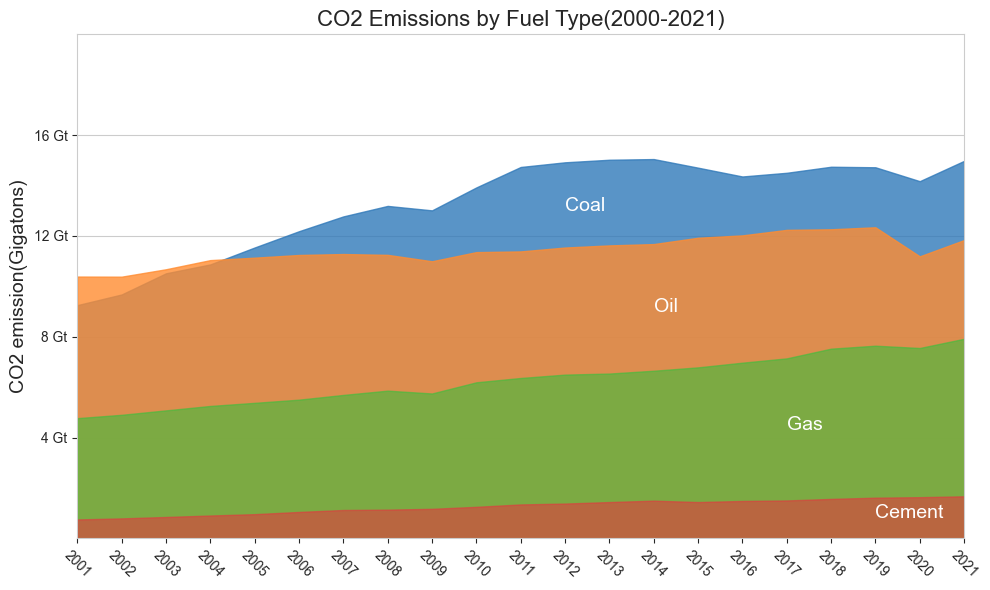

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
emissions_by_fuel_type = ems.groupby('Year')[['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']].sum().reset_index()


# Set up the plot
#sns.set_style('whitegrid', {'axes.grid': True, 'axes.grid.axis': 'y', 'xtick.bottom': True, 'ytick.left': True})
sns.set_style('whitegrid', {'axes.grid': False, 'axes.grid.axis': 'y', 'xtick.bottom': True, 'ytick.left': True})

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.fill_between(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Coal'], color='#3079b9', label='Coal', alpha=0.8)
ax.fill_between(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Oil'], color='#ff8c31', label='Oil', alpha=0.8)
ax.fill_between(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Gas'], color='#3cbf3c', label='Gas', alpha=0.6)
ax.fill_between(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Cement'], color='#e2393f', label='Cement', alpha=0.6)

# Customize the plot
ax.set_xticks(emissions_by_fuel_type['Year'])
ax.set_xticklabels(emissions_by_fuel_type['Year'], rotation=-45)

# Set the x-axis limits to the minimum and maximum years
ax.set_xlim(emissions_by_fuel_type['Year'].min(), emissions_by_fuel_type['Year'].max())

ax.set_yticks([4e3, 8e3, 12e3, 16e3])
ax.set_yticklabels(['4 Gt', '8 Gt', '12 Gt', '16 Gt'])
ax.set_ylim(0, 20e3)
ax.set_ylabel('CO2 emission(Gigatons)', fontsize=14)


# Add text annotations
ax.text(2012, 13e3, 'Coal', color='white', size=14)
ax.text(2014, 9e3, 'Oil', color='white', size=14)
ax.text(2017, 4.3e3, 'Gas', color='white', size=14)
ax.text(2019, 0.8e3, 'Cement', color='white', size=14)

# Set the horizontal grid
plt.grid(axis='y')
plt.title('CO2 Emissions by Fuel Type(2000-2021)', fontsize=16)
plt.tight_layout()
plt.show()


### YourName 2

In [1]:
# Insert your code here

### YourName 3

In [ ]:
# Insert your code here

### YourName 4

In [ ]:
# Insert your code here